In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV

In [2]:
# The data are in a txt file, so we can use pd.read_csv to read it into a Dataframe
df = pd.read_csv('./../data/Kozut/2022_05_16_(zeg_hosszutav_2).txt', names=['acc1','acc2','acc3','acc4','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z','gps_lat','gps_lon','abs_time'],sep=';')
# The labels for a later supervised learning are in another file, so read that too, then join it to the main 'df' dataframe
df['ref'] = pd.read_csv('./../data/Kozut/2022_05_16_(zeg_hosszutav_2)_minoseg_ref_2_v2.csv', names=['ref'],sep=';')

print(df.shape)
df.head() #check it

(170904, 14)


,acc1,acc2,acc3,acc4,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
0,2145,2257,0,0,-2.525883,0.220267,8.959103,7.465649,0.274809,-0.671756,4.684318e+01,16.829527,1.652697e+12,1
1,2145,2252,0,0,-2.525883,0.220267,8.959103,7.625954,0.259542,-0.496183,1.652697e+12,NaN,NaN,1
2,2144,2254,0,0,-2.525883,0.220267,8.959103,7.366412,0.549618,-0.404580,1.652697e+12,NaN,NaN,1
3,2143,2255,0,0,-2.525883,0.220267,8.959103,7.122137,0.519084,-0.412214,1.652697e+12,NaN,NaN,1
4,2143,2256,0,0,-2.525883,0.220267,8.959103,7.183206,0.381679,-0.412214,1.652697e+12,NaN,NaN,1


# Data cleaning

In [3]:
df.describe()

,acc1,acc2,acc3,acc4,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
count,170904.000000,170904.000000,170904.0,170904.0,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,1.709040e+05,1693.000000,1.693000e+03,170904.000000
mean,2147.534669,2397.971487,0.0,0.0,-2.434307,0.165553,8.986625,7.221301,0.358250,-0.353842,1.636326e+12,16.837546,1.652697e+12,2.423951
std,97.603936,323.140142,0.0,0.0,0.860807,0.689129,0.991239,2.417523,2.564998,3.987587,1.636761e+11,0.009411,3.415591e+05,0.996491
min,561.000000,0.000000,0.0,0.0,-5.887342,-3.098097,4.632780,-13.603053,-34.984733,-37.114504,4.680779e+01,16.822841,1.652697e+12,1.000000
25%,2111.000000,2200.000000,0.0,0.0,-2.887407,-0.148441,8.506598,6.198473,-0.770992,-1.106870,1.652697e+12,16.828460,1.652697e+12,2.000000
50%,2150.000000,2444.000000,0.0,0.0,-2.449268,0.186748,8.987833,7.267176,0.358779,-0.511450,1.652697e+12,16.835625,1.652697e+12,3.000000
75%,2182.000000,2639.000000,0.0,0.0,-2.015918,0.469264,9.459491,8.251908,1.488550,0.183206,1.652698e+12,16.847543,1.652698e+12,3.000000
max,4095.000000,4095.000000,0.0,0.0,2.633622,3.021482,13.934254,29.832061,27.167939,29.305344,1.652698e+12,16.851392,1.652698e+12,4.000000


In [4]:
df.info() 
#we can see that some columns contains much less values than others: this is because the sample rate for the GPS unit and time unit was lower than the vibration measurement sensor 
#(because the vibration data must be sampled at high frequency, as it is essentially a high frequency signal) ---> we have to handle this soon, with an interpolation we will replace the NaN values easily

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170904 entries, 0 to 170903
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   acc1       170904 non-null  int64  
 1   acc2       170904 non-null  int64  
 2   acc3       170904 non-null  int64  
 3   acc4       170904 non-null  int64  
 4   imu_acc_x  170904 non-null  float64
 5   imu_acc_y  170904 non-null  float64
 6   imu_acc_z  170904 non-null  float64
 7   imu_gy_x   170904 non-null  float64
 8   imu_gy_y   170904 non-null  float64
 9   imu_gy_z   170904 non-null  float64
 10  gps_lat    170904 non-null  float64
 11  gps_lon    1693 non-null    float64
 12  abs_time   1693 non-null    float64
 13  ref        170904 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 18.3 MB


<Axes: ylabel='ref'>

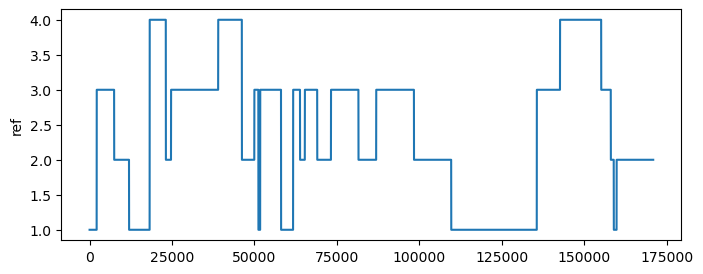

In [5]:
plt.figure(figsize=(8,3))
sns.lineplot(df['ref']) #fast check on the label column

In [6]:
# Interpolate gps and time data to replace missing rows caused by different sampling rate
# We use the numpy's interp function

fp = np.arange(0,len(df),101) #The x-coordinates of the data points
x = np.arange(0,len(df)) #The x-coordinates at which to evaluate the interpolated values

for j in ['gps_lat','gps_lon','abs_time']:  #let's replace NaN values in these columns
    xp = df.loc[np.arange(0,len(df),101),j]
    df[j] = np.interp(x, fp, xp) #The y-coordinates of the data points, same length as xp.

df.head()

,acc1,acc2,acc3,acc4,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
0,2145,2257,0,0,-2.525883,0.220267,8.959103,7.465649,0.274809,-0.671756,46.843183,16.829527,1.652697e+12,1
1,2145,2252,0,0,-2.525883,0.220267,8.959103,7.625954,0.259542,-0.496183,46.843183,16.829527,1.652697e+12,1
2,2144,2254,0,0,-2.525883,0.220267,8.959103,7.366412,0.549618,-0.404580,46.843183,16.829527,1.652697e+12,1
3,2143,2255,0,0,-2.525883,0.220267,8.959103,7.122137,0.519084,-0.412214,46.843183,16.829527,1.652697e+12,1
4,2143,2256,0,0,-2.525883,0.220267,8.959103,7.183206,0.381679,-0.412214,46.843183,16.829527,1.652697e+12,1


In [7]:
# Delete acc3 and acc4 columns (these sensors were not activated at the mesurement)

df.drop(['acc3','acc4'],axis=1,inplace=True)
df.head()

,acc1,acc2,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
0,2145,2257,-2.525883,0.220267,8.959103,7.465649,0.274809,-0.671756,46.843183,16.829527,1.652697e+12,1
1,2145,2252,-2.525883,0.220267,8.959103,7.625954,0.259542,-0.496183,46.843183,16.829527,1.652697e+12,1
2,2144,2254,-2.525883,0.220267,8.959103,7.366412,0.549618,-0.404580,46.843183,16.829527,1.652697e+12,1
3,2143,2255,-2.525883,0.220267,8.959103,7.122137,0.519084,-0.412214,46.843183,16.829527,1.652697e+12,1
4,2143,2256,-2.525883,0.220267,8.959103,7.183206,0.381679,-0.412214,46.843183,16.829527,1.652697e+12,1


#### Remove low frequency bias

,acc1,acc2,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
170899,2.718211,38.065573,-0.352326,0.193435,-0.040848,0.576257,-2.188610,-5.803041,46.84326,16.830079,1.652698e+12,2
170900,-18.281868,63.071992,-0.352327,0.193435,-0.040848,-1.301606,-2.058839,-5.841207,46.84326,16.830079,1.652698e+12,2
170901,-20.281947,102.078411,-0.352327,0.193434,-0.040848,0.713661,-1.852732,-5.612197,46.84326,16.830079,1.652698e+12,2
170902,-20.282026,42.084829,-0.352328,0.193434,-0.040848,0.896867,-1.990136,-5.528226,46.84326,16.830079,1.652698e+12,2
170903,-5.282105,74.091246,-0.352329,0.193433,-0.040849,-1.347408,-2.264946,-5.215247,46.84326,16.830079,1.652698e+12,2


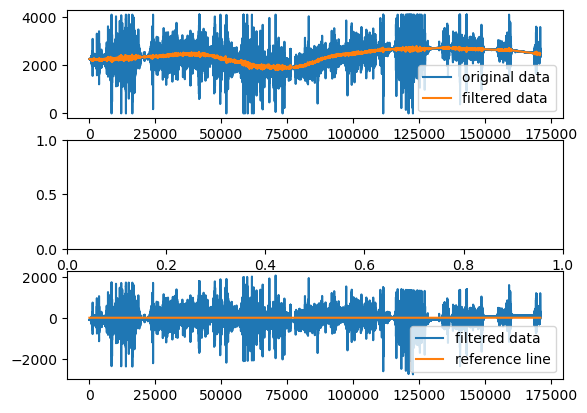

In [8]:
# For the non-linear trend I use a custom fitting gunction, while for linear trend, I use the scipy built-in detrend function

df_filtered = df

## acc1 variable

df_filtered['acc1'] = scipy.signal.detrend(df['acc1'])

## acc2 variable

# Remove variation by movmean

def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

filtered = moving_average(df['acc2'].to_numpy())

fig, ax = plt.subplots(3)

ax[0].plot(df.index, df['acc2'])
ax[0].plot(filtered[:-1])
ax[0].legend(['original data', 'filtered data'])


# Fitting with Fourier function

a0 = 2396
a1 = 79.55
b1 = -251.8
a2 = -125.5
b2 = 118.7
w = 3.477e-05

fitting = []
for x in range(len(df)):
    temp_fitting = a0 + a1*np.cos(x*w) + b1*np.sin(x*w) + a2*np.cos(2*x*w) + b2*np.sin(2*x*w)
    fitting.append(temp_fitting)

# Substract this polynom from the original data

df_filtered['acc2'] = df['acc2']-fitting


ax[2].plot(df_filtered['acc2'])
ax[2].plot(np.ones((len(df),1)))
ax[2].legend(['filtered data', 'reference line'])

## imu_acc variables

df_filtered['imu_acc_x'] = (scipy.signal.detrend(df['imu_acc_x']))
df_filtered['imu_acc_y'] = (scipy.signal.detrend(df['imu_acc_y']))
df_filtered['imu_acc_z'] = (scipy.signal.detrend(df['imu_acc_z']))

## imu_gy variables

df_filtered['imu_gy_x'] = (scipy.signal.detrend(df['imu_gy_x']))
df_filtered['imu_gy_y'] = (scipy.signal.detrend(df['imu_gy_y']))
df_filtered['imu_gy_z'] = (scipy.signal.detrend(df['imu_gy_z']))

df.tail()

,acc1,acc2,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z,gps_lat,gps_lon,abs_time,ref
count,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,170904.000000,1.709040e+05,170904.000000
mean,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,46.829380,16.837550,1.652697e+12,2.423951
std,0.025012,0.041256,0.083582,0.106986,0.100251,0.053492,0.036287,0.054454,0.014025,0.009409,3.412829e+05,0.996491
min,0.092351,0.000000,0.169737,0.000000,0.059408,0.038935,0.000000,0.000000,46.807786,16.822841,1.652697e+12,1.000000
25%,0.490832,0.479927,0.456936,0.451414,0.451715,0.477400,0.484040,0.489490,46.814433,16.828449,1.652697e+12,2.000000
50%,0.500110,0.500077,0.495578,0.500396,0.499793,0.500640,0.500029,0.498609,46.833267,16.835651,1.652697e+12,3.000000
75%,0.508781,0.520972,0.540401,0.546771,0.547386,0.522831,0.516001,0.507368,46.843827,16.847542,1.652698e+12,3.000000
max,1.000000,0.873464,1.000000,0.935642,1.000000,1.000000,0.879284,0.904266,46.846814,16.851392,1.652698e+12,4.000000


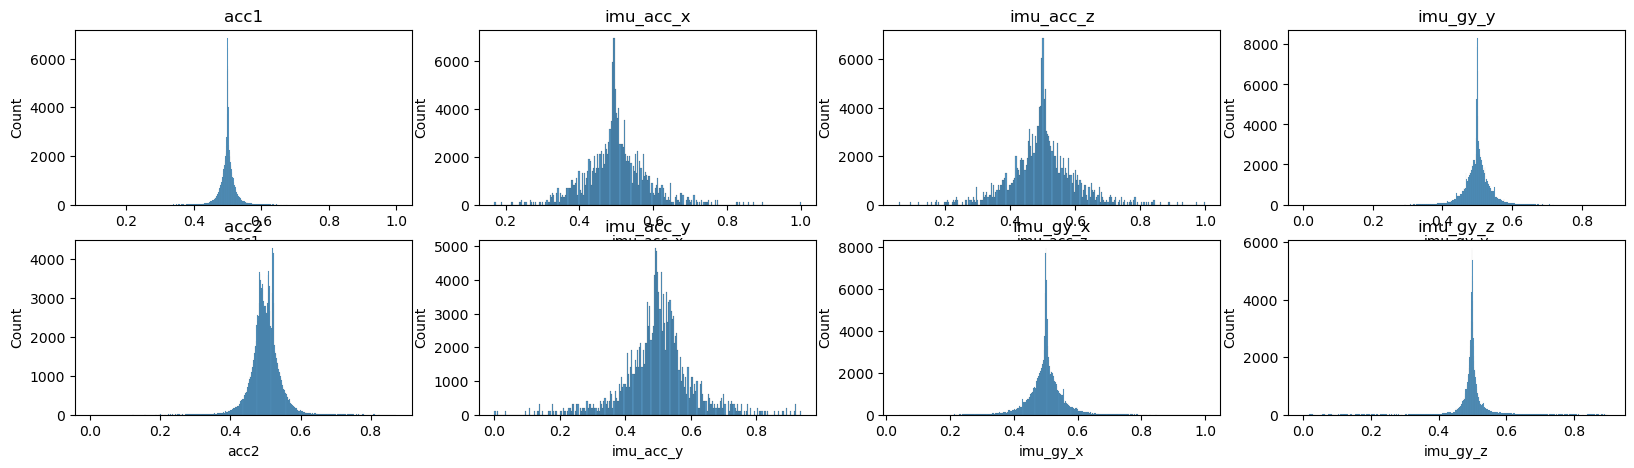

In [9]:
# Rescale vibration data with a custom function

def normalize(values):
    return (values/values.abs().max())/2+0.5

df_scaled_ss = df_filtered[['acc1','acc2','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z']].apply(normalize)
df_scaled_ss['gps_lat'] = df['gps_lat']
df_scaled_ss['gps_lon'] = df['gps_lon']
df_scaled_ss['abs_time'] = df['abs_time']
df_scaled_ss['ref'] = df['ref']

# Check the normalized values on plot and with the describe function
fig, axs = plt.subplots(2,4,figsize=(20, 5))
sns.histplot(ax=axs[0,0], x=df_scaled_ss['acc1'])
axs[0, 0].set_title('acc1')
sns.histplot(ax=axs[1,0], x=df_scaled_ss['acc2'])
axs[1, 0].set_title('acc2')
sns.histplot(ax=axs[0,1], x=df_scaled_ss['imu_acc_x'])
axs[0, 1].set_title('imu_acc_x')
sns.histplot(ax=axs[1,1], x=df_scaled_ss['imu_acc_y'])
axs[1, 1].set_title('imu_acc_y')
sns.histplot(ax=axs[0,2], x=df_scaled_ss['imu_acc_z'])
axs[0, 2].set_title('imu_acc_z')
sns.histplot(ax=axs[1,2], x=df_scaled_ss['imu_gy_x'])
axs[1, 2].set_title('imu_gy_x')
sns.histplot(ax=axs[0,3], x=df_scaled_ss['imu_gy_y'])
axs[0, 3].set_title('imu_gy_y')
sns.histplot(ax=axs[1,3], x=df_scaled_ss['imu_gy_z'])
axs[1, 3].set_title('imu_gy_z')

df_scaled_ss.describe()

#### Time-domain to Space-domain

In [10]:
# For the time-domain --- spatial-domain conversion we need the distance between each sample point. We can calculate this according to the GPS coordinates and mathematical functions. The dDist contains this distances.

dDist = []
for j in np.arange(2,len(df)):
    d = abs(np.arccos(np.cos(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j-1])) * np.cos(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j])) + np.sin(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j-1])) * np.sin(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j]))) * np.cos(np.deg2rad(df_scaled_ss['gps_lon'].loc[j-1]-df_scaled_ss['gps_lon'].loc[j])) * 3958.76);
    dDist.append(d)
df_dDist = pd.DataFrame(dDist)
df_dDist.fillna(0,inplace=True) #remove the NaN values, introduced from the above calculation
df_dDist.isna().value_counts()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5744\2455117266.py:5: RuntimeWarning: invalid value encountered in arccos
  d = abs(np.arccos(np.cos(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j-1])) * np.cos(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j])) + np.sin(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j-1])) * np.sin(np.deg2rad(90-df_scaled_ss['gps_lat'].loc[j]))) * np.cos(np.deg2rad(df_scaled_ss['gps_lon'].loc[j-1]-df_scaled_ss['gps_lon'].loc[j])) * 3958.76);


False    170902
Name: count, dtype: int64

In [11]:
#summed = np.cumsum(df_dDist)*1000
summed = np.cumsum(df_dDist.to_numpy())*1000   #calculated the total travelles distance by cumsum function
uniqe_indexes = np.unique(summed,return_index=True)
#uniqe_indexes
#xp[uniqe_indexes[1]]
x = np.arange(0,max(summed),0.2)

# Then we use again the interp function to convert the time domain to the spatial domain
df_spatial = pd.DataFrame()
for j in ['acc1','acc2','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z','gps_lat','gps_lon','abs_time','ref']:
    xp = df_scaled_ss[j]
    df_spatial[j] = np.interp(x,uniqe_indexes[0],xp[uniqe_indexes[1]])

# Spatial resample done!


## Spectral analysis with Fourier transformation

In [12]:
#calculate the average sampling frequency for the spectrogram below
fs = 1/((np.diff(df_spatial['abs_time'])/1000).mean()) # dt in sec ## fs in Hz

In [13]:
from scipy import signal
from scipy.fft import fftshift

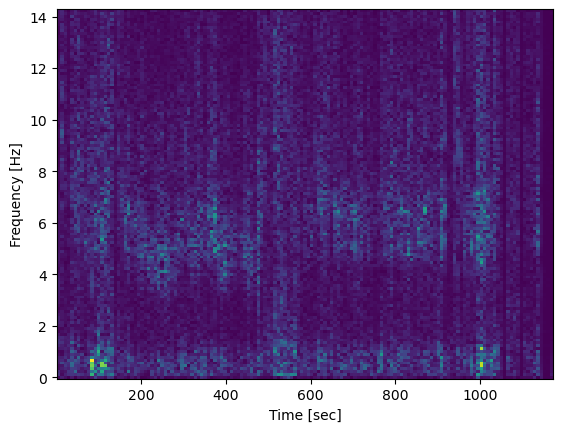

In [14]:
f, t, Sxx = signal.spectrogram(df_spatial['imu_gy_y'], fs, scaling='density',mode='magnitude')  # Plot the spectrogram for one variable
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [15]:
#Calculate the spectrogram for every variable with a for cycle

df_spectral = pd.DataFrame()

for i in ['acc1','acc2','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z']:
   f, t, Sxx = signal.spectrogram(df_spatial[i], fs, scaling='density',mode='magnitude')
   spectral = []
   for j in np.arange(0,Sxx.shape[1]):
      x = np.sum(Sxx[:,j])
      spectral.append(x)
   df_spectral[i] = spectral

df_spectral

,acc1,acc2,imu_acc_x,imu_acc_y,imu_acc_z,imu_gy_x,imu_gy_y,imu_gy_z
0,0.082251,0.215029,0.668049,0.910899,0.492162,0.947129,0.356725,1.138149
1,0.375591,0.562014,0.844312,0.721317,0.894650,0.952541,0.654890,0.376016
2,0.240585,0.385979,0.376442,0.711447,0.662744,0.627736,0.413021,0.194517
3,0.142112,0.266032,1.322389,0.434057,0.527888,0.388660,0.325227,0.147787
4,0.511579,0.449560,0.474236,0.918447,1.188266,1.085658,0.785359,0.256605
...,...,...,...,...,...,...,...,...
144,0.585731,0.903229,0.781889,0.482792,0.904393,1.243529,0.909872,0.233319
145,0.106037,0.161869,0.691630,0.307913,0.967405,0.502502,0.264492,0.165164
146,0.007102,0.010207,0.031512,0.092023,0.109210,0.037167,0.025197,0.026248
147,0.005753,0.010500,0.079642,0.037895,0.109378,0.039812,0.021940,0.026203


## PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA()
pca.fit(df_spectral[['acc1','acc2','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z']])
df_pca = pca.transform(df_spectral[['acc1','acc2','imu_acc_x','imu_acc_y','imu_acc_z','imu_gy_x','imu_gy_y','imu_gy_z']])

<Axes: >

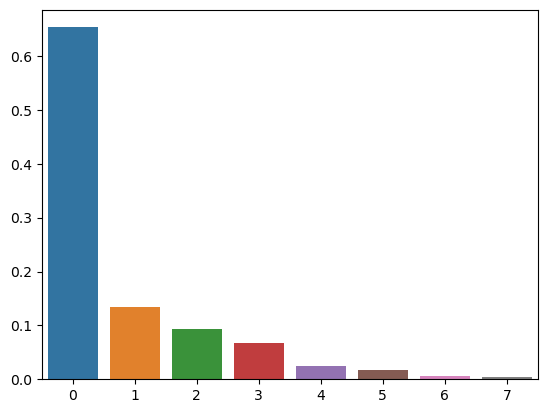

In [18]:
sns.barplot(x=np.arange(0,len(pca.explained_variance_ratio_)),y=pca.explained_variance_ratio_)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


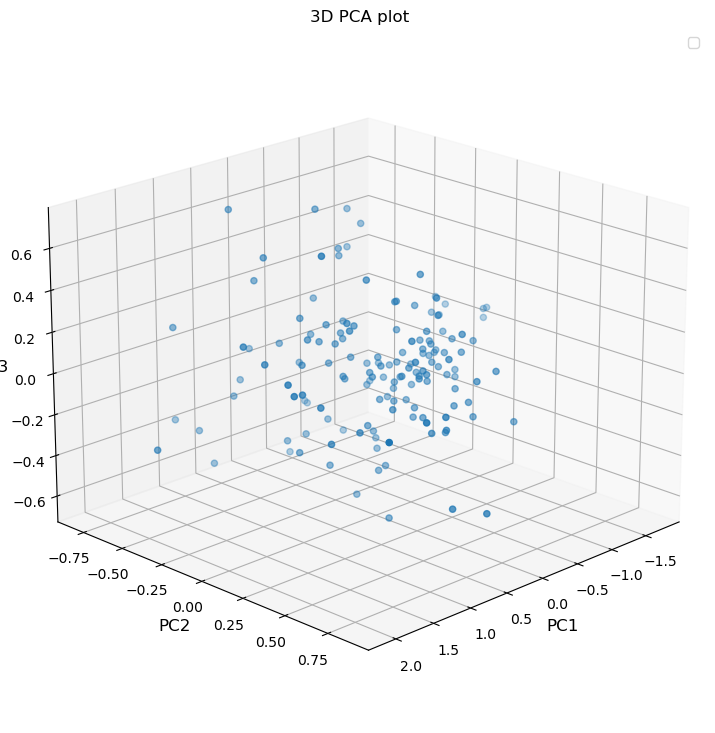

In [19]:
Xax = df_pca[:,0]
Yax = df_pca[:,1]
Zax = df_pca[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(projection='3d')

cdict = {1:'m',2:'c',3:'r',4:'g'}
label = {1:'1',2:'2',3:'3',4:'4'}

"""
y = ref['q']
for l in np.unique(y):
 ix=np.where(y==l)[0]
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=1,
           label=label[l],
           alpha=0.2)
"""
ax.scatter(Xax, Yax, Zax)


ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)

ax.view_init(20, 45)
ax.legend()
plt.title("3D PCA plot")
plt.show()

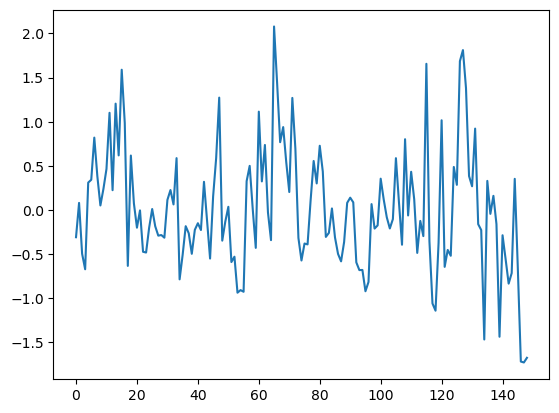

In [20]:
plt.plot(df_pca[:,0])